In [173]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function

# The main mapwork module
from enlib import enmap

import numpy as np
# Tools for working with enmaps, i/o, catalogs and statistics
from orphics import maps,io,stats,cosmology,lensing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:

def get_cls(iparams,ells):
    lc = cosmology.LimberCosmology(iparams.copy(),low_acc=False,lmax=6000,skipCls=True,kmax=42.47,zmax=3.0,nonlinear=True,numz=3000)
    zwid = 0.2
    zs = np.arange(0.5,3,0.5)
    for i,z in enumerate(zs):
        print(i,z)
        lc.addStepNz("%d" % i,z-zwid/2.,z+zwid/2.)
        
    lc.generateCls(ells)
    ps = np.zeros((zs.size,zs.size,ells.size))
    for i in range(len(zs)):
        for j in range(i,len(zs)):
            ps[i,j] = lc.getCl("%d" % i,"%d" % j)
            ps[j,i] = ps[i,j].copy()
    
    return ps
     
ells = np.arange(0,5000,1)
params = cosmology.defaultCosmology.copy()
params['mnu'] = 0.1
ps_fid = get_cls(params,ells)
print(ps.shape)

initializing power...
Initializing CMB window..
0 0.5
('Initializing galaxy window for ', '0', ' ...')
1 1.0
('Initializing galaxy window for ', '1', ' ...')
2 1.5
('Initializing galaxy window for ', '2', ' ...')
3 2.0
('Initializing galaxy window for ', '3', ' ...')
4 2.5
('Initializing galaxy window for ', '4', ' ...')
(5, 5, 5000)


In [175]:
print(params)

{'tau': 0.06, 'H0': 67.0, 'mnu': 0.1, 'As': 2.2e-09, 'omch2': 0.1247, 'w0': -1.0, 'ns': 0.96, 'ombh2': 0.0223}


In [176]:
vparams = ['As','omch2','mnu']
steps = [0.1e-9,0.003,0.005]

dps = {}
for vparam,step in zip(vparams,steps):
    pparams = params.copy()
    pparams[vparam] += step/2.
    ps_up = get_cls(pparams,ells)
    
    pparams = params.copy()
    pparams[vparam] -= step/2.
    ps_dn = get_cls(pparams,ells)
    
    dps[vparam] = (ps_up-ps_dn)/step

initializing power...
Initializing CMB window..
0 0.5
('Initializing galaxy window for ', '0', ' ...')
1 1.0
('Initializing galaxy window for ', '1', ' ...')
2 1.5
('Initializing galaxy window for ', '2', ' ...')
3 2.0
('Initializing galaxy window for ', '3', ' ...')
4 2.5
('Initializing galaxy window for ', '4', ' ...')
initializing power...
Initializing CMB window..
0 0.5
('Initializing galaxy window for ', '0', ' ...')
1 1.0
('Initializing galaxy window for ', '1', ' ...')
2 1.5
('Initializing galaxy window for ', '2', ' ...')
3 2.0
('Initializing galaxy window for ', '3', ' ...')
4 2.5
('Initializing galaxy window for ', '4', ' ...')
initializing power...
Initializing CMB window..
0 0.5
('Initializing galaxy window for ', '0', ' ...')
1 1.0
('Initializing galaxy window for ', '1', ' ...')
2 1.5
('Initializing galaxy window for ', '2', ' ...')
3 2.0
('Initializing galaxy window for ', '3', ' ...')
4 2.5
('Initializing galaxy window for ', '4', ' ...')
initializing power...
Initializ

[8.63773346e-10 5.75631596e-10 6.84046515e-10 1.03629329e-09
 1.79040344e-09]


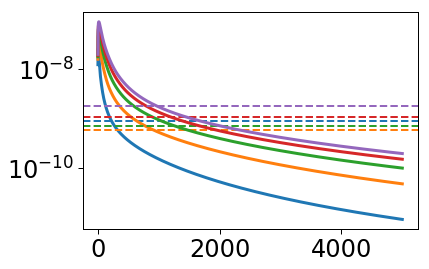

[[8.63773346e-10 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 5.75631596e-10 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.84046515e-10 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.03629329e-09
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.79040344e-09]]


In [177]:
zs = np.arange(0.5,3,0.5)
def shear_noise(z, shape_noise = 0.3):
    z_arr = np.arange(0.5,3,0.5)      
    ngal_arr = np.array([8.83, 13.25, 11.15, 7.36, 4.26])
    if z in z_arr:                    
        ngal = ngal_arr[np.where(z_arr==z)]
    else:                            
        ngal = 0                      
    return shape_noise**2./(ngal*1.18e7) 
print(shear_noise(zs))

pl = io.Plotter(yscale='log')
for i in range(len(zs)):
    pl.add(ells,ps_fid[i,i],lw=3,color="C%d"%i)
    pl._ax.axhline(y=shear_noise(zs[i]),ls="--",lw=2,color="C%d"%i)
    
pl.done()

Ncov = np.diag(shear_noise(zs))
print(Ncov)

In [178]:
import itertools
Fisher = np.zeros((3,3))
pcombs = itertools.combinations_with_replacement(vparams,2)
fsky = 20000./41252.
lmin = 100
lmax = 5000
for param1,param2 in pcombs:
    Fell = 0.
    i = vparams.index(param1)
    j = vparams.index(param2)
    print(param1,param2)
    for ell in ells[lmin:lmax]:
        Cov = ps_fid[:,:,ell]+Ncov
        InvCov = np.linalg.inv(Cov)
        dCov1 = dps[param1][:,:,ell]
        dCov2 = dps[param2][:,:,ell]
        
        Fell += (2.*ell+1.) * fsky * np.trace(np.dot(np.dot(InvCov,dCov1),np.dot(InvCov,dCov2))) /2.
        Fisher[i,j] = Fell
        Fisher[j,i] = Fell
                

As As
As omch2
As mnu
omch2 omch2
omch2 mnu
mnu mnu


In [179]:
F = stats.FisherMatrix(Fisher,vparams)

In [180]:
print(F)

                 As         omch2           mnu
As     6.160061e+23  2.311502e+16 -3.060083e+14
omch2  2.311502e+16  8.706194e+08 -1.140945e+07
mnu   -3.060083e+14 -1.140945e+07  1.553394e+05


In [181]:
print(F.sigmas())

{'As': 3.883101881576696e-11, 'omch2': 0.0007809355482152751, 'mnu': 0.02441462926960755}


In [78]:
import cPickle as pickle
pickle.dump(dps,open("pickled_derivatives_powers.pkl",'wb'))

In [82]:
ds = pickle.load(open("pickled_derivatives_powers.pkl",'rb'))
ds['As'][0,0]

(5000,)

initializing power...
Initializing CMB window..
0 0.5
('Initializing galaxy window for ', '0', ' ...')
1 1.0
('Initializing galaxy window for ', '1', ' ...')
2 1.5
('Initializing galaxy window for ', '2', ' ...')
3 2.0
('Initializing galaxy window for ', '3', ' ...')
4 2.5
('Initializing galaxy window for ', '4', ' ...')
initializing power...
Initializing CMB window..
0 0.5
('Initializing galaxy window for ', '0', ' ...')
1 1.0
('Initializing galaxy window for ', '1', ' ...')
2 1.5
('Initializing galaxy window for ', '2', ' ...')
3 2.0
('Initializing galaxy window for ', '3', ' ...')
4 2.5
('Initializing galaxy window for ', '4', ' ...')
initializing power...
Initializing CMB window..
0 0.5
('Initializing galaxy window for ', '0', ' ...')
1 1.0
('Initializing galaxy window for ', '1', ' ...')
2 1.5
('Initializing galaxy window for ', '2', ' ...')
3 2.0
('Initializing galaxy window for ', '3', ' ...')
4 2.5
('Initializing galaxy window for ', '4', ' ...')
initializing power...
Initializ

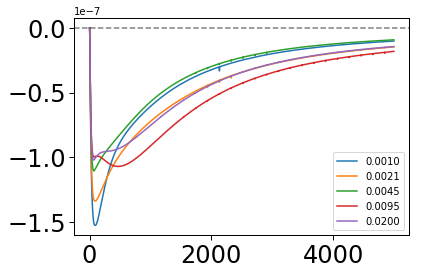

In [182]:
def dparam(fids,vparam,step,ells):
    pparams = fids.copy()
    pparams[vparam] += step/2.
    ps_up = get_cls(pparams,ells)
    
    pparams = params.copy()
    pparams[vparam] -= step/2.
    ps_dn = get_cls(pparams,ells)
    
    return (ps_up-ps_dn)/step

pl = io.Plotter()
for step in np.logspace(np.log10(0.001),np.log10(0.02),5):
    dcl = dparam(params.copy(),"mnu",step,ells)
    pl.add(ells,ells*dcl[0,0],label="%0.4f"%step)
pl.legend(loc='lower right')
pl.hline()
pl.done()

initializing power...
Initializing CMB window..
0 0.5
('Initializing galaxy window for ', '0', ' ...')
1 1.0
('Initializing galaxy window for ', '1', ' ...')
2 1.5
('Initializing galaxy window for ', '2', ' ...')
3 2.0
('Initializing galaxy window for ', '3', ' ...')
4 2.5
('Initializing galaxy window for ', '4', ' ...')
initializing power...
Initializing CMB window..
0 0.5
('Initializing galaxy window for ', '0', ' ...')
1 1.0
('Initializing galaxy window for ', '1', ' ...')
2 1.5
('Initializing galaxy window for ', '2', ' ...')
3 2.0
('Initializing galaxy window for ', '3', ' ...')
4 2.5
('Initializing galaxy window for ', '4', ' ...')
initializing power...
Initializing CMB window..
0 0.5
('Initializing galaxy window for ', '0', ' ...')
1 1.0
('Initializing galaxy window for ', '1', ' ...')
2 1.5
('Initializing galaxy window for ', '2', ' ...')
3 2.0
('Initializing galaxy window for ', '3', ' ...')
4 2.5
('Initializing galaxy window for ', '4', ' ...')
initializing power...
Initializ

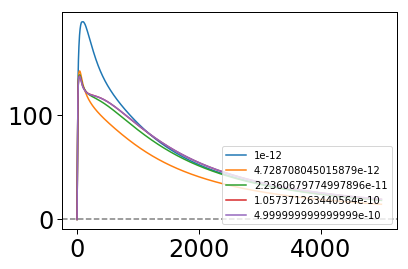

In [183]:
def dparam(fids,vparam,step,ells):
    pparams = fids.copy()
    pparams[vparam] += step/2.
    ps_up = get_cls(pparams,ells)
    
    pparams = params.copy()
    pparams[vparam] -= step/2.
    ps_dn = get_cls(pparams,ells)
    
    return (ps_up-ps_dn)/step

pl = io.Plotter()
for step in np.logspace(np.log10(0.001e-9),np.log10(0.5e-9),5):
    dcl = dparam(params.copy(),"As",step,ells)
    pl.add(ells,ells*dcl[0,0],label=str(step))
pl.legend(loc='lower right')
pl.hline()
pl.done()

In [ ]:
def dparam(fids,vparam,step,ells):
    pparams = fids.copy()
    pparams[vparam] += step/2.
    ps_up = get_cls(pparams,ells)
    
    pparams = params.copy()
    pparams[vparam] -= step/2.
    ps_dn = get_cls(pparams,ells)
    
    return (ps_up-ps_dn)/step

pl = io.Plotter()
for step in np.logspace(np.log10(0.0003),np.log10(0.001),5):
    dcl = dparam(params.copy(),"omch2",step,ells)
    pl.add(ells,ells*dcl[0,0],label=str(step))
pl.legend(loc='lower right')
pl.hline()
pl.done()

initializing power...
Initializing CMB window..
0 0.5
('Initializing galaxy window for ', '0', ' ...')
1 1.0
('Initializing galaxy window for ', '1', ' ...')
2 1.5
('Initializing galaxy window for ', '2', ' ...')
3 2.0
('Initializing galaxy window for ', '3', ' ...')
4 2.5
('Initializing galaxy window for ', '4', ' ...')
initializing power...
Initializing CMB window..
0 0.5
('Initializing galaxy window for ', '0', ' ...')
1 1.0
('Initializing galaxy window for ', '1', ' ...')
2 1.5
('Initializing galaxy window for ', '2', ' ...')
3 2.0
('Initializing galaxy window for ', '3', ' ...')
4 2.5
('Initializing galaxy window for ', '4', ' ...')
initializing power...
Initializing CMB window..
0 0.5
('Initializing galaxy window for ', '0', ' ...')
1 1.0
('Initializing galaxy window for ', '1', ' ...')
2 1.5
('Initializing galaxy window for ', '2', ' ...')
3 2.0
('Initializing galaxy window for ', '3', ' ...')
4 2.5
('Initializing galaxy window for ', '4', ' ...')
initializing power...
Initializ